# Multi-Channel Audio Visualization

## Data Loading and Preparation
- The script loads metadata from a JSON file containing recording session information
- It constructs file paths to audio chunks based on metadata
- The first audio chunk is loaded as a NumPy array with shape (number of samples, number of channels)
- Analysis focuses on the first 20 seconds of audio data (as specified in metadata)

## Visualization Types

### 1. Waveform Visualization
- Displays the raw amplitude over time for the first channel
- Provides basic temporal characteristics of the audio signal
- Helps identify regions of silence, speech, or other acoustic events

### 2. Power Spectral Density (PSD)
- Computes the frequency distribution of signal power using Welch's method
- Uses a 4096-sample window for good frequency resolution
- Reveals dominant frequencies in the recording (e.g., drone motor frequencies)
- Logarithmic scale helps visualize wide range of power values

### 3. Spectrogram Analysis
- Creates a time-frequency representation showing how spectral content changes over time
- Uses 1024-sample windows with overlap
- Converts magnitude to decibels for better visibility
- Color intensity indicates energy level at each time-frequency point

### 4. Channel Energy Comparison
- Calculates RMS (Root Mean Square) energy in 100ms windows for all channels
- Plots energy levels over time for each channel
- Enables comparison of signal strength across the microphone array
- Helpful for identifying directional characteristics of sound sources

### 5. 3D Multi-Channel Spectrogram
- Creates a three-dimensional visualization showing time-frequency content for multiple channels
- Selects a subset of channels (up to 5) for clarity
- Downsamples the data for better visualization performance
- Offsets each channel's surface plot for clear separation
- Provides spatial-spectral overview of the recording

### 6. Spatial Energy Distribution (Polar Plot)
- For 16-channel UMA-16V2 array recordings only
- Creates a polar plot showing average energy distribution across channels
- Assumes microphones are arranged in a circle
- Visualizes the directional characteristics of the sound field
- Helps identify direction of arrival for sound sources

Sample rate: 44100 Hz
Audio data shape: (882000, 16)
Analyzing 20 seconds (882000 samples)


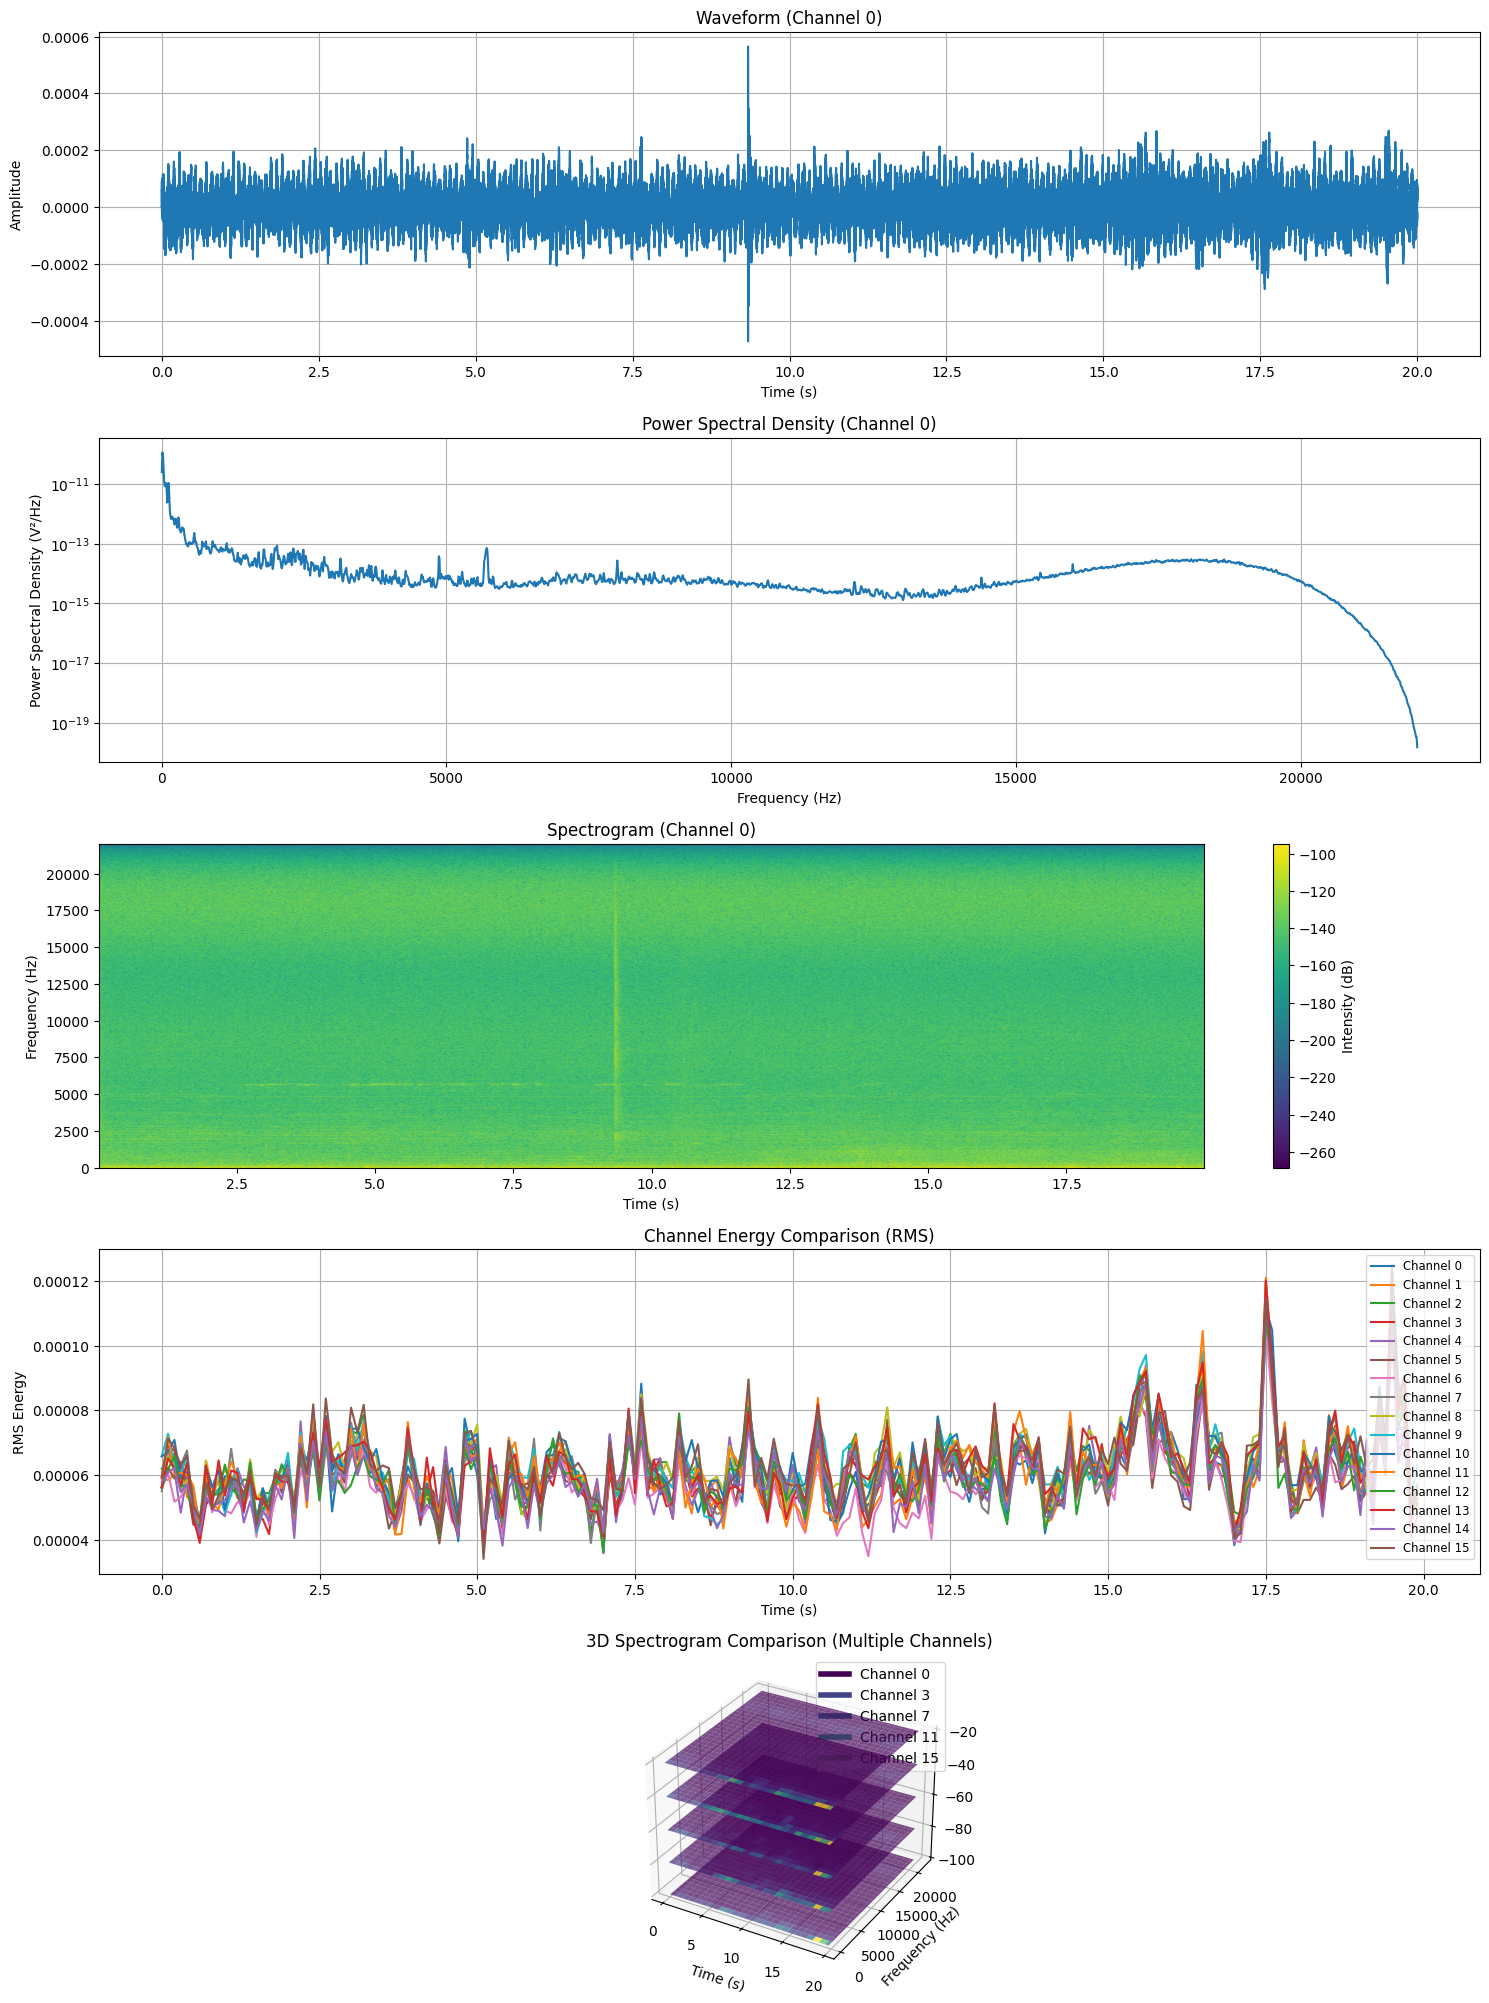

In [8]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram
from scipy import signal
import pandas as pd
import librosa
import librosa.display

# Configuration
cfg = {
    'metadata_local_path_str': '/home/grace/Develop/ziz/2025-04-21_19-08-01_Session1_MJ_Brown Building Apartments_Sunny/metadata.json'
}

if __name__ == '__main__':
    # Open and read the metadata file
    metadata_json = Path(cfg['metadata_local_path_str'])
    local_path = metadata_json.parent
    
    with metadata_json.open('r') as f:
        metadata = json.load(f)
    
    # Collect audio chunk paths
    audio_chunks_over_time = []
    for audio_metadata in metadata['audio_chunks_timestamps']:
        orig_path = Path(audio_metadata['file_name'])
        last_two = orig_path.parts[-2:]
        audio_path = local_path.joinpath(*last_two)
        audio_chunks_over_time.append(audio_path)
    
    # Load the first audio chunk
    idx = 0
    audio_data_np = np.load(audio_chunks_over_time[idx])  # shape: (n_samples, n_channels)
    expected_sample_rate = int(metadata['sound_card_sample_rate'])
    print(f'Sample rate: {expected_sample_rate} Hz')
    print(f'Audio data shape: {audio_data_np.shape}')
    
    # Use first 20 seconds (according to chunk size in metadata)
    duration_seconds = metadata['chunk_size_in_seconds']
    num_samples = min(int(expected_sample_rate * duration_seconds), audio_data_np.shape[0])
    print(f'Analyzing {duration_seconds} seconds ({num_samples} samples)')
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(15, 20))
    
    # ===== PLOT 1: Waveform of first channel =====
    plt.subplot(5, 1, 1)
    time = np.arange(num_samples) / expected_sample_rate
    channel = 0  # First channel
    plt.plot(time, audio_data_np[:num_samples, channel])
    plt.title(f'Waveform (Channel {channel})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # ===== PLOT 2: Power Spectral Density =====
    plt.subplot(5, 1, 2)
    freqs, power = welch(audio_data_np[:num_samples, channel], fs=expected_sample_rate, nperseg=4096)
    plt.semilogy(freqs, power)
    plt.title(f'Power Spectral Density (Channel {channel})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (V²/Hz)')
    plt.grid(True)
    
    # ===== PLOT 3: Spectrogram =====
    plt.subplot(5, 1, 3)
    f, t, Sxx = spectrogram(audio_data_np[:num_samples, channel], fs=expected_sample_rate, nperseg=1024)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title(f'Spectrogram (Channel {channel})')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Intensity (dB)')
    
    # ===== PLOT 4: Channel Comparison (RMS Energy) =====
    plt.subplot(5, 1, 4)
    
    # Calculate RMS energy for each channel
    n_channels = min(16, audio_data_np.shape[1])  # Use up to 16 channels
    channel_energies = []
    
    for ch in range(n_channels):
        # Calculate RMS energy in 100ms windows
        window_size = int(expected_sample_rate * 0.1)
        n_windows = num_samples // window_size
        energy = []
        
        for i in range(n_windows):
            start = i * window_size
            end = (i + 1) * window_size
            segment = audio_data_np[start:end, ch]
            rms = np.sqrt(np.mean(np.square(segment)))
            energy.append(rms)
        
        channel_energies.append(energy)
    
    # Create time axis for energy plot
    energy_time = np.arange(len(channel_energies[0])) * 0.1  # 100ms windows
    
    # Plot energies for each channel
    for ch in range(n_channels):
        plt.plot(energy_time, channel_energies[ch], label=f'Channel {ch}')
    
    plt.title('Channel Energy Comparison (RMS)')
    plt.xlabel('Time (s)')
    plt.ylabel('RMS Energy')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    
    # ===== PLOT 5: 3D Visualization (Multiple channels over time and frequency) =====
    plt.subplot(5, 1, 5, projection='3d')
    
    # Select a subset of channels for clarity
    channels_to_plot = min(5, n_channels)
    channel_indices = np.linspace(0, n_channels-1, channels_to_plot, dtype=int)
    
    for i, ch in enumerate(channel_indices):
        # Calculate spectrogram
        f, t, Sxx = spectrogram(audio_data_np[:num_samples, ch], fs=expected_sample_rate, nperseg=1024)
        
        # Downsample for visualization
        freq_step = max(1, len(f) // 50)
        time_step = max(1, len(t) // 50)
        
        f_downsample = f[::freq_step]
        t_downsample = t[::time_step]
        Sxx_downsample = Sxx[::freq_step, ::time_step]
        
        # Convert to dB for better visualization
        Sxx_db = 10 * np.log10(Sxx_downsample + 1e-10)
        
        # Create meshgrid for 3D plot
        T, F = np.meshgrid(t_downsample, f_downsample)
        
        # Plot as surface with offset based on channel number
        offset = i * 20  # Offset each channel for visibility
        ax = plt.gca()
        surf = ax.plot_surface(T, F, Sxx_db + offset, cmap='viridis', alpha=0.7)
    
    plt.title('3D Spectrogram Comparison (Multiple Channels)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Add custom legend for channels
    from matplotlib.lines import Line2D
    legend_elements = []
    for i, ch in enumerate(channel_indices):
        legend_elements.append(Line2D([0], [0], color=plt.cm.viridis(i/channels_to_plot), lw=4, label=f'Channel {ch}'))
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('audio_visualization.png', dpi=300)
    plt.show()

# Training Acoustic Model

## Data Preprocessing Pipeline

The acoustic model processes audio data through several key steps before training:

### 1. Input Format Transformation
- **Spectrograms** are used as input instead of raw audio signals
- Spectrograms provide frequency-domain representation that better captures acoustic patterns

### 2. Audio Signal Resampling
- All six microphone channels are **resampled to 48kHz**
- This ensures uniform sample rate across all audio inputs
- Consistent sample rate is critical for model training stability

### 3. Temporal Segmentation
- Each channel's audio stream is divided into **1-second chunks**
- These chunks are further subdivided into **30 segments**
- Each segment corresponds to a single frame from the synchronized video data
- This creates time-aligned audio-visual data pairs

### 4. Spectrogram Generation
- **Short-Time Fourier Transform (STFT)** is applied to each audio segment
- STFT parameters:
  - **Hamming window function** for better frequency resolution
  - **Window size of 512 samples**
  - **4 hops** per window (hop length = 128 samples)
- This configuration yields spectrograms with dimensions **[257, 376]**
  - 257 frequency bins
  - 376 time frames

### 5. Channel Stacking
- Spectrograms from all 6 channels for each segment are **stacked together**
- This preserves spatial audio information from the microphone array
- The resulting multi-channel spectrograms serve as input to the neural network

Original sample rate: 44100 Hz
Audio data shape: (882000, 16)
Resampled audio shape: (960001, 6)


/tmp/ipykernel_2077780/2994945382.py:24: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),


Spectrogram shape: (257, 376)


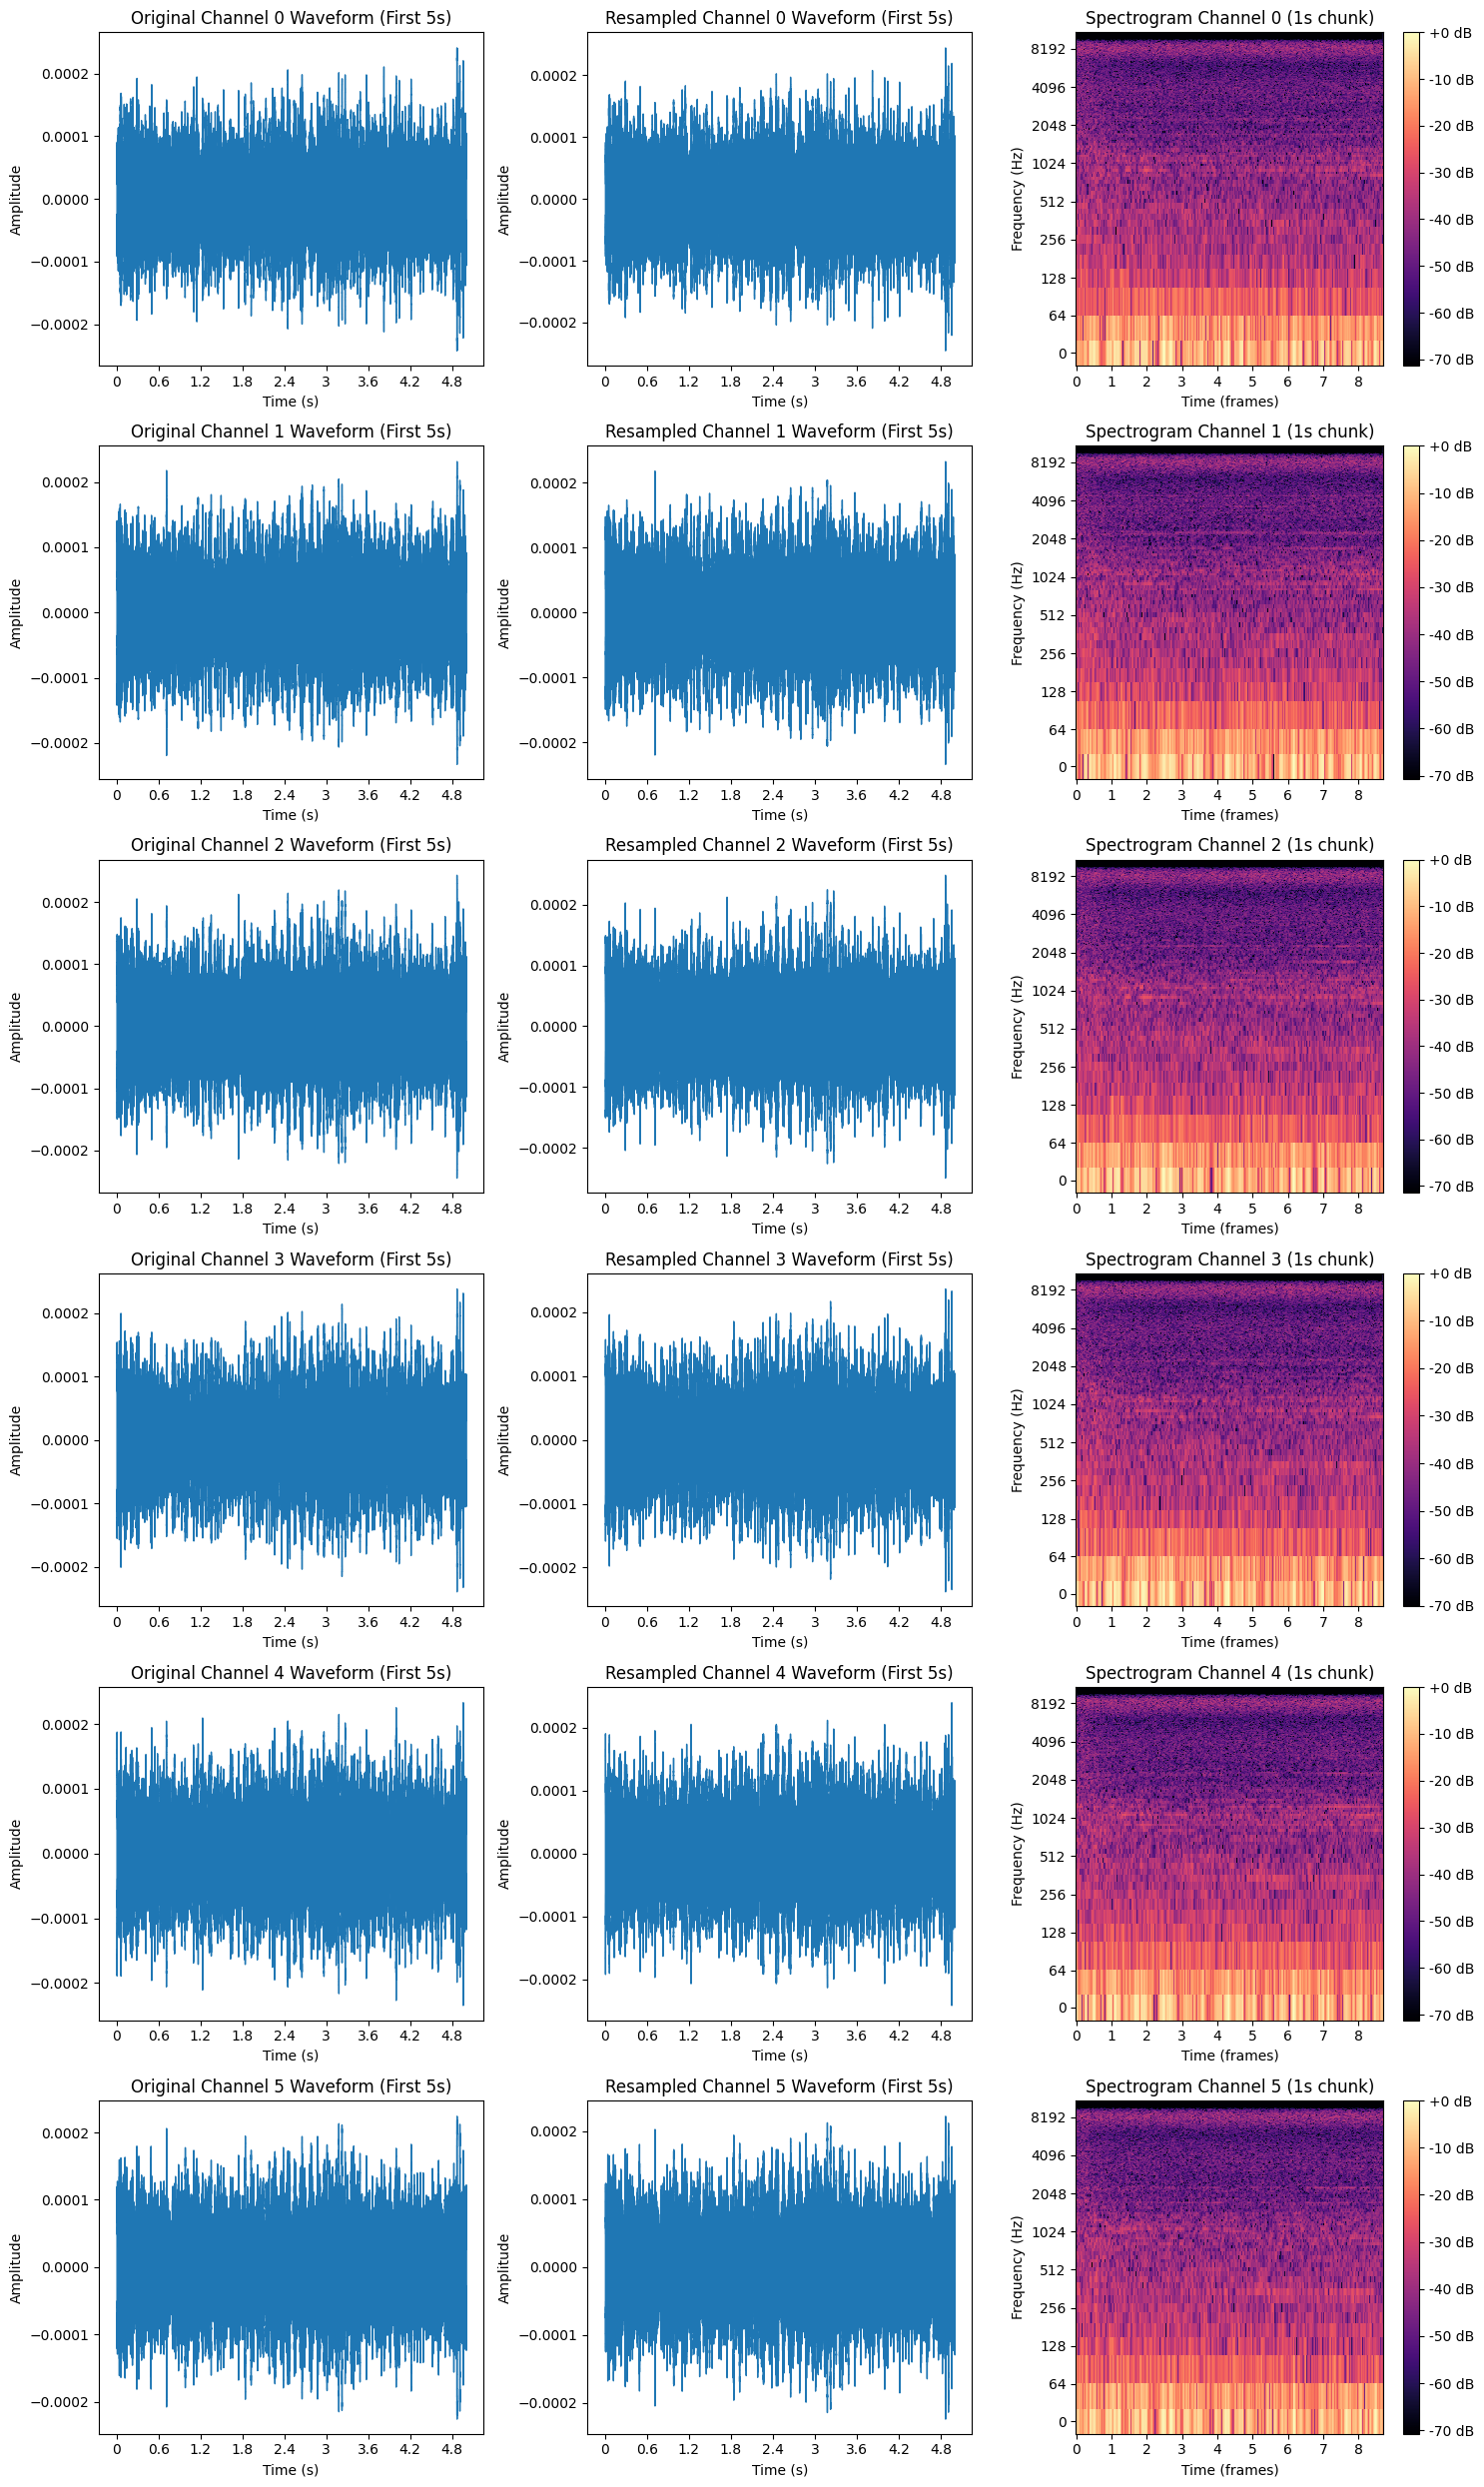

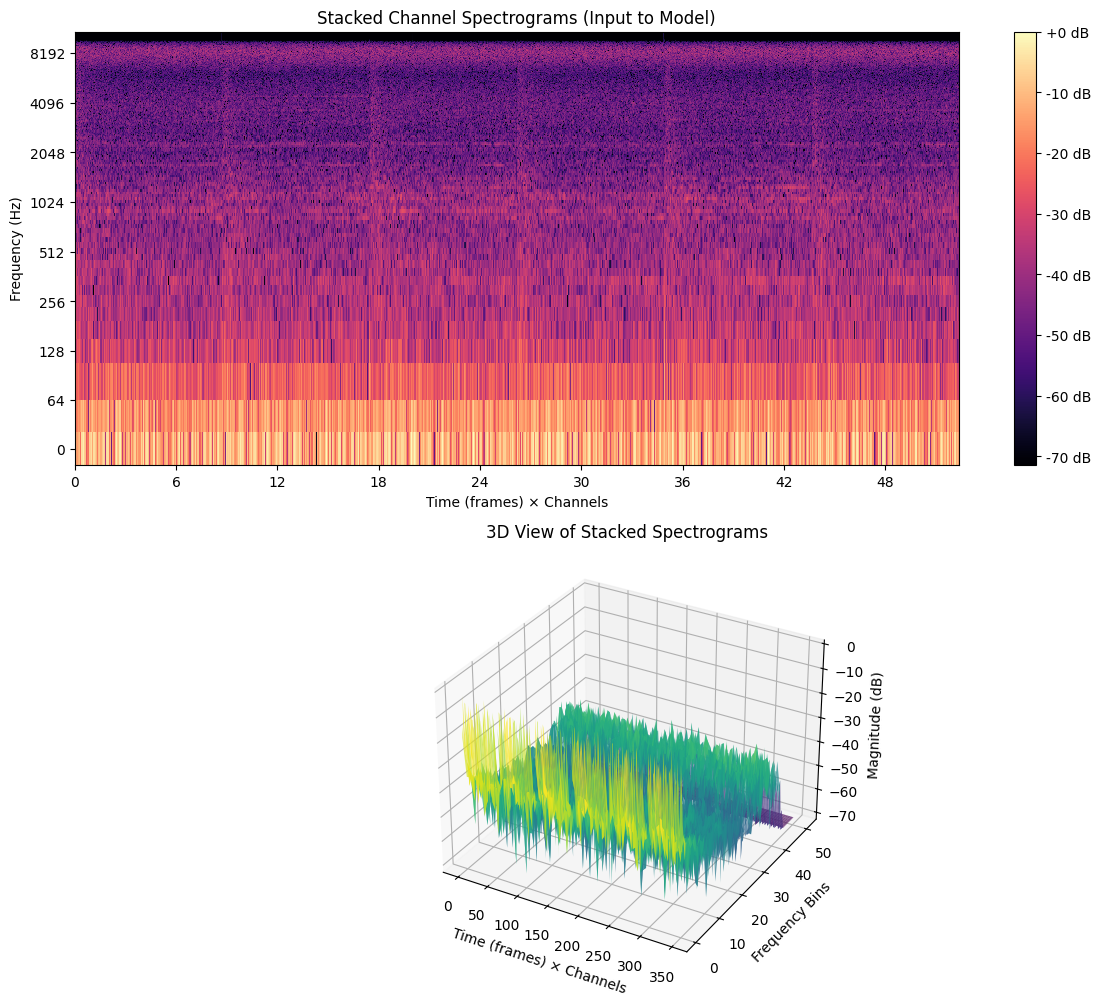

In [9]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import pandas as pd

# Configuration
cfg = {
    'metadata_local_path_str': '/home/grace/Develop/ziz/2025-04-21_19-08-01_Session1_MJ_Brown Building Apartments_Sunny/metadata.json'
}

def plot_waveform(audio_data, sr, title, ax):
    """Plot a waveform of audio data."""
    librosa.display.waveshow(audio_data, sr=sr, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

def plot_spectrogram(spectrogram, title, ax):
    """Plot a spectrogram."""
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                             y_axis='log', x_axis='time', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Time (frames)")
    ax.set_ylabel("Frequency (Hz)")
    plt.colorbar(ax.collections[0], ax=ax, format='%+2.0f dB')

if __name__ == '__main__':
    # Open and read the metadata file
    metadata_json = Path(cfg['metadata_local_path_str'])
    local_path = metadata_json.parent
    
    with metadata_json.open('r') as f:
        metadata = json.load(f)
    
    # Collect audio chunk paths
    audio_chunks_over_time = []
    for audio_metadata in metadata['audio_chunks_timestamps']:
        orig_path = Path(audio_metadata['file_name'])
        last_two = orig_path.parts[-2:]
        audio_path = local_path.joinpath(*last_two)
        audio_chunks_over_time.append(audio_path)
    
    # Load the first audio chunk
    idx = 0
    audio_data_np = np.load(audio_chunks_over_time[idx])  # shape: (n_samples, n_channels)
    original_sample_rate = int(metadata['sound_card_sample_rate'])
    print(f'Original sample rate: {original_sample_rate} Hz')
    print(f'Audio data shape: {audio_data_np.shape}')

    # According to instructions, we should use 6 channels
    # If there are more, we'll take the first 6
    num_channels = min(6, audio_data_np.shape[1])
    
    # Create a figure for the full preprocessing pipeline
    fig = plt.figure(figsize=(15, 25))
    
    # STEP 1: Original audio waveform for each channel
    orig_axes = []
    for ch in range(num_channels):
        ax = plt.subplot(num_channels, 3, ch*3 + 1)
        plot_waveform(audio_data_np[:5*original_sample_rate, ch], original_sample_rate, 
                     f"Original Channel {ch} Waveform (First 5s)", ax)
        orig_axes.append(ax)
    
    # STEP 2: Resample to 48kHz
    target_sample_rate = 48000
    
    # Don't pre-allocate with fixed size - resample each channel first, then stack
    resampled_channels = []
    
    for ch in range(num_channels):
        # Resample each channel individually
        resampled_channel = librosa.resample(
            audio_data_np[:, ch], 
            orig_sr=original_sample_rate, 
            target_sr=target_sample_rate
        )
        resampled_channels.append(resampled_channel)
    
    # Find the minimum length (to handle any potential length differences)
    min_length = min(len(channel) for channel in resampled_channels)
    
    # Create the final array with consistent dimensions
    resampled_audio = np.zeros((min_length, num_channels))
    for ch in range(num_channels):
        resampled_audio[:, ch] = resampled_channels[ch][:min_length]
    
    print(f'Resampled audio shape: {resampled_audio.shape}')
    
    # Plot resampled waveforms
    resampled_axes = []
    for ch in range(num_channels):
        ax = plt.subplot(num_channels, 3, ch*3 + 2)
        plot_waveform(resampled_audio[:5*target_sample_rate, ch], target_sample_rate, 
                     f"Resampled Channel {ch} Waveform (First 5s)", ax)
        resampled_axes.append(ax)
    
    # STEP 3: Divide into 1s chunks and compute spectrograms
    chunk_duration = 1  # 1 second chunks
    samples_per_chunk = target_sample_rate * chunk_duration
    
    # Select the first chunk for demonstration
    first_chunk = resampled_audio[:samples_per_chunk, :]
    
    # Set STFT parameters as specified
    n_fft = 512  # Window size
    hop_length = n_fft // 4  # 4 Hops as specified
    
    # Compute and display spectrograms for each channel
    spec_axes = []
    spectrograms = []
    
    for ch in range(num_channels):
        # Apply STFT with Hamming window
        spectrogram = librosa.stft(
            first_chunk[:, ch], 
            n_fft=n_fft, 
            hop_length=hop_length, 
            window='hamming'
        )
        spectrograms.append(spectrogram)
        
        # Plot spectrogram
        ax = plt.subplot(num_channels, 3, ch*3 + 3)
        plot_spectrogram(spectrogram, f"Spectrogram Channel {ch} (1s chunk)", ax)
        spec_axes.append(ax)
    
    plt.tight_layout()
    # plt.savefig('preprocessing_visualization.png', dpi=300)
    
    # Create a new figure to show the stacked spectrograms (input to the model)
    plt.figure(figsize=(12, 10))
    
    # Stack spectrograms and visualize
    # First, convert to magnitude spectrograms
    mag_specs = [np.abs(spec) for spec in spectrograms]
    
    # Check the shape
    first_spec_shape = mag_specs[0].shape
    print(f"Spectrogram shape: {first_spec_shape}")  # Should be close to [257×273]
    
    # Visualize the stacked spectrograms as input to the model
    # We'll create a grid of mini-spectrograms and then show a 3D representation
    
    # 2D grid visualization
    plt.subplot(2, 1, 1)
    combined_spec = np.hstack(mag_specs)
    librosa.display.specshow(
        librosa.amplitude_to_db(combined_spec, ref=np.max),
        y_axis='log', 
        x_axis='time'
    )
    plt.title("Stacked Channel Spectrograms (Input to Model)")
    plt.xlabel("Time (frames) × Channels")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(format='%+2.0f dB')
    
    # 3D visualization of the stacked spectrograms
    ax = plt.subplot(2, 1, 2, projection='3d')
    
    for ch in range(num_channels):
        # Get the spectrogram for this channel
        spec = librosa.amplitude_to_db(mag_specs[ch], ref=np.max)
        
        # Downsample for visualization clarity
        freq_step = max(1, spec.shape[0] // 50)
        time_step = max(1, spec.shape[1] // 50)
        spec_downsampled = spec[::freq_step, ::time_step]
        
        # Create a meshgrid
        x, y = np.meshgrid(
            np.arange(0, spec_downsampled.shape[1]),
            np.arange(0, spec_downsampled.shape[0])
        )
        
        # Add channel offset for 3D visualization
        x = x + ch * (spec_downsampled.shape[1] + 5)
        
        # Plot as a surface
        surf = ax.plot_surface(
            x, y, spec_downsampled,
            cmap=plt.cm.viridis,
            alpha=0.7
        )
    
    ax.set_title("3D View of Stacked Spectrograms")
    ax.set_xlabel("Time (frames) × Channels")
    ax.set_ylabel("Frequency Bins")
    ax.set_zlabel("Magnitude (dB)")
    
    plt.tight_layout()
    # plt.savefig('stacked_spectrograms_input.png', dpi=300)

# Potential pipeline tool: ADIOS2

High performance I/O framework. 

Using this framework would favor real-time streaming of step-based audio data to multiple processing components with lower latency. 

(not sure how large the dataset will get)

### Example: 

In [10]:
# Producer (audio capture)
import adios2
import numpy as np

# Initialize ADIOS2
adios = adios2.ADIOS()
io = adios.DeclareIO("DroneAudioStream")
io.SetEngine("SST")
io.SetParameters({"QueueLimit": "5", "DataTransport": "RDMA"})

# Create audio variable (16 channels)
audio_var = io.DefineVariable("AudioData", 
                             shape=[chunk_samples, 16], 
                             start=[0, 0],
                             count=[chunk_samples, 16])

# Add metadata as attributes
io.DefineAttribute("session_name", "2025-04-21_19-08-01_Session1_MJ_Brown Building Apartments_Sunny")
io.DefineAttribute("audio_sensor_name", "UMA-16V2 USB Mic Array")
io.DefineAttribute("sample_rate", 44100)
# ... add other metadata

# Open stream
writer = io.Open("DroneAudio", adios2.Mode.Write)

# In audio capture loop
while capturing:
    # Capture 20 seconds of audio data
    audio_chunk = capture_audio(duration=20)  # Your capture function
    
    # Begin step and write data
    writer.BeginStep()
    writer.Put(audio_var, audio_chunk)
    writer.EndStep()

writer.Close()

# Continue high performance data preprocessing ? 

AttributeError: module 'adios2' has no attribute 'ADIOS'